# InferSent - Demonstration

This notebook serves as a demonstration of the usage of a trained InferSent model, as well as training and performance results on the original SNLI task and on SentEval. The notebook also provides some error analysis (discussion) on the results.

## Setup

The notebook assumes the user has access to the pretrained models, logs and evaluation results provided via the [archive.org](https://archive.org) link specified in `README.md`. The notebook also assumes the user has run the `data.py` script with its default arguments such that aligned glove embeddings are available.

First we define our imports

In [1]:
import pickle

import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

from models.infersent import InferSent
import utils

We continue by defining a configuration dictionary that we can access throughout the demo. Of course we can change the values of our config accordingly.

In [2]:
demo_config = {
    # one of 'baseline', 'lstm', 'bilstm', 'maxpoolbilstm'
    "encoder_type": "maxpoolbilstm",
    # path to model checkpoint. by default we load the maxpoolbilstm
    "checkpoint_path": "logs/maxpoolbilstm/version_3/checkpoints/epoch=6-step=60088.ckpt",
    # random seed for reproducibility
    "seed": 42,
    # where to load aligned GloVe torch tensor from
    "aligned_glove": "data/aligned_glove.pt",
}

## Model Loading

We can instantiate the model we will use from the checkpoint path we defined. Because the GloVe embeddings are not saved in the model, after instatiating our model we load them into it in a separate call.

In [3]:
# instantiate pretrained model
infsent_model = InferSent.load_from_checkpoint(demo_config["checkpoint_path"])
# load aligned GloVe embeddings from disk
aligned_glove = torch.load(demo_config["aligned_glove"])
# and load them into our model
infsent_model.load_embeddings(aligned_glove)

## Inference examples

The InferSent model is trained to perform Natural Language Inference (NLI), i.e. predicting whether a "hypothesis" sentence is true ("entailment"), not true ("contradiction") or neither ("neutral") given a "premise" sentence.

This task is a "proxy" task used for training an encoder sub-model that can be used to embed sentences.

Below, we will first see how we can use the model for performing NLI and then how we can use its encoder to obtain an embedding (vector).

### NLI

Here is our model predicting the entailment between a few pairs of sentences

In [4]:
# first, a quick helper function for printing
def print_entailment_res(premise, hypothesis, result):
    print(f"premise: {premise}")
    print(f"hypothesis: {hypothesis}")
    print(f"model prediction: {result}")
    print("------------\n")


In [5]:
# entailment example from SciTail
premise_1 = "A concave lens is thinner in the middle than it is near its edges."
hypothesis_1 = "A concave lens is thicker at the edges than it is in the middle."
result_1 = infsent_model.predict(premise_1, hypothesis_1)
print_entailment_res(premise_1, hypothesis_1, result_1)

# contradiction example from multiNLI
premise_2 = "but that takes too much planning"
hypothesis_2 = "It doesn't take much planning."
result_2 = infsent_model.predict(premise_2, hypothesis_2)
print_entailment_res(premise_2, hypothesis_2, result_2)

# neutral example from SciTail
premise_3 = "Energy, heat and/or sound are forms of matter"
hypothesis_3 = "Heat, light, and sound are all different forms of energy."
result_3 = infsent_model.predict(premise_3, hypothesis_3)
print_entailment_res(premise_3, hypothesis_3, result_3)

premise: A concave lens is thinner in the middle than it is near its edges.
hypothesis: A concave lens is thicker at the edges than it is in the middle.
model prediction: entailment
------------

premise: but that takes too much planning
hypothesis: It doesn't take much planning.
model prediction: contradiction
------------

premise: Energy, heat and/or sound are forms of matter
hypothesis: Heat, light, and sound are all different forms of energy.
model prediction: neutral
------------



Don't trust that those weren't just hard-coded in the model? Try with some sentences of your own!

In [6]:
# replace these strings and rerun this cell
premise_yours = "Replace this string with your premise."
hypothesis_yours = "Replace this string with your hypothesis."
result_yours = infsent_model.predict(premise_yours, hypothesis_yours)

print_entailment_res(premise_yours, hypothesis_yours, result_yours)

premise: Replace this string with your premise.
hypothesis: Replace this string with your hypothesis.
model prediction: neutral
------------



### Sentence Encoding

Here is our model encoding a few sentences. Of course, just embedding a sentence is quite useless if you don't do anything with the embedding afterwards, but this is just a quick demonstration which can be extended.

In [7]:
# first a helper function
def visualize_embedding(sentence, embedding, ylim=None):
    print(embedding)
    plt.figure(figsize=(12, 2))
    plt.title(f"'{sentence}'")
    plt.xlabel("dimension")
    plt.bar(np.arange(len(embedding)), embedding.cpu().numpy())
    plt.tight_layout()
    if ylim:
        plt.ylim(ylim)
    plt.show()
    print("\n")

tensor([ 0.0513, -0.0105,  0.0309,  ...,  0.0399, -0.0280,  0.1223])


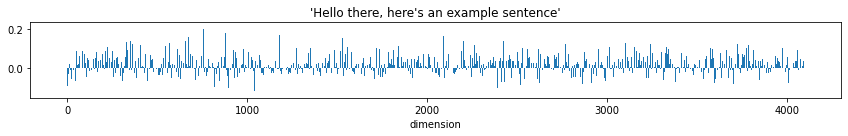



tensor([ 0.0546, -0.0350, -0.0233,  ...,  0.0780,  0.1136, -0.0037])


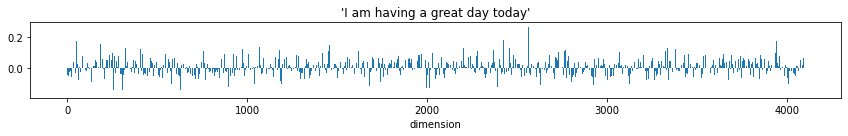



tensor([ 0.0681, -0.0522,  0.0188,  ...,  0.0529,  0.1298,  0.0826])


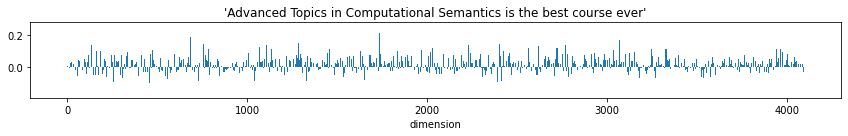

In [8]:
sentence_1 = "Hello there, here's an example sentence"
embedding_1 = infsent_model.encoder.encode(sentence_1).squeeze()
visualize_embedding(sentence_1, embedding_1)

sentence_2 = "I am having a great day today"
embedding_2 = infsent_model.encoder.encode(sentence_2).squeeze()
visualize_embedding(sentence_2, embedding_2)

sentence_3 = "Advanced Topics in Computational Semantics is the best course ever"
embedding_3 = infsent_model.encoder.encode(sentence_3).squeeze()
visualize_embedding(sentence_3, embedding_3)

Try it with your own sentence!

tensor([ 0.0619,  0.0379,  0.0548,  ...,  0.0199, -0.0375,  0.1120])


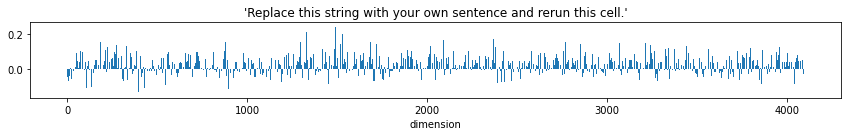

In [9]:
sentence_yours = "Replace this string with your own sentence and rerun this cell."
embedding_yours = infsent_model.encoder.encode(sentence_yours).squeeze()
visualize_embedding(sentence_yours, embedding_yours)

## Results

### Training/Validation Loss/Accuracy Curves

Training/Validation loss and accuracy were logged in a tensorboard-compatible
format. We can load tensorboard directly in the notebook and view them. Users
are suggested to do the following:

1. change to the `TIME SERIES` tab on the top,
2. pin the `train_acc`, `train_loss` `val_acc`, `val_loss` metrics
3. activate all the runs on the left hand side except `maxpoolbilstm/version_1`,
   as these are the runs corresponding to the best model for each encoder type.

In [10]:
%load_ext tensorboard
%tensorboard --logdir logs

A few observations can be made with regards to the learning curves. First, from the validation accuracy curves we can see a clear difference in performance between the baseline model and the LSTM models, with the Max-pooled BiLSTM achieving the highest validation accuracy throughout. From these curves it is interesting to note the similarity in performance between the LSTM and the 'plain' BiLSTM, which actually does marginally worse albeit training for slightly less epochs. It is unclear why this occurs, especially since the BiLSTM contains the same information as the LSTM and could just learn to discard the additional concatenated information from the reversed LSTM. This may be explained by overfitting, with further evidence from the BiLSTM training accuracy being higher than the LSTM. This, combined with the much slower training time (2.05 hours vs 3.895 hours), indicates that the 'plain' BiLSTM is a worse choice than the LSTM, at least when it comes to SNLI (we will see and discuss SentEval performance later).

On the subject of training time, we can gather more insights by hovering over the curves. While we see that the implemented early stopping criterion (stop when learning rate goes under $10^{-5}$) causes all models to end training between 12-15 epochs, the underlying run time is quite different, ranging from 26 minutes for the baseline model to 3.992 hours for the MaxPoolBiLSTM model. This range can be appreciated by changing the x-axis to relative.

One may argue that the stopping criterion outlined in the paper was a bit too lenient and users may have benefited time-wise from more informed criterions. The behaviour of the validation loss curves in the LSTM-based models, with an initial dip followed by a slow rise may have been useful, particularly in combination with the validation accuracy curves. Perhaps the authors intuited that longer training could lead to better generalized sentence encoders at the expense of slightly worse NLI performance. This is similar reasoning as for why the same encoder is used for hypothesis and premise as opposed to using two separate specialized encoders.

One final observation can be made by activating only the MaxPoolBiLSTM runs (version 1 and 3). Here, version 1 is an "incorrect" implementation of the MaxPoolBiLSTM described by the authors, where the padded values of 0 hidden states the LSTM are not masked out as they should be, to avoid incorrectly selecting them when max-pooling hiddenstates with only negative values. Despite this incorrectness, this version seems to outperform the "correct" implementation in terms of validation accuracy. One possible explanation for this is that not masking out the 0's somewhat simulates the application of a ReLU non-linearity, which generally makes networks more expressive. Another explanation can be that the zeros could mimic some kind of frankensteined dropout. Regardless, the difference in performance is somewhat marginal and for the moment devoid of an estimated uncertainty, making it difficult to rigorously compare. Because we were interesting in replicating parts of the original work, the `version_1` was disregarded for the rest of the work.

### Performance Evaluation

We've so far examined what our models can do, and how they behaved while training. How do they do in testing? For this, we evaluate our models both on the original SNLI task, as well as the SentEval sentence embedding evaluation suite, particularly the 'MR', 'CR', 'SUBJ', 'MPQA', 'SST2', 'TREC', 'MRPC', and 'SICKEntailment' transfer tasks. This is done via `eval.py`. After some parsing of the results, we report "micro" and "macro" validation set accuracy on the transfer tasks, where "macro" refers to the classical average accuracy across the tasks while "micro" refers to the average accuracy across the tasks weighted by the number of samples.

In [11]:
# basic setup datastructures
senteval_tasks = {"MR", "CR", "SUBJ", "MPQA", "SST2", "TREC", "MRPC", "SICKEntailment"}
eval_data = {
    "baseline": {
        "name": "Baseline",
        "dim": 300,
        "snli": {},
        "senteval": {},
    },
    "lstm": {
        "name": "LSTM",
        "dim": 2048,
        "snli": {},
        "senteval": {},
    },
    "bilstm": {
        "name": "BiLSTM",
        "dim": 4096,
        "snli": {},
        "senteval": {},
    },
    "maxpoolbilstm": {
        "name": "BiLSTM-Max",
        "dim": 4096,
        "snli": {},
        "senteval": {},
    },
}

In [12]:
for model in eval_data.keys():
    with open(f"logs/{model}/eval/snli/val.pkl", "rb") as f:
        eval_data[model]["snli"]["val"] = pickle.load(f)[0]["val_acc"]
    with open(f"logs/{model}/eval/snli/test.pkl", "rb") as f:
        eval_data[model]["snli"]["test"] = pickle.load(f)[0]["test_acc"]
    with open(f"logs/{model}/eval/senteval/results.pkl", "rb") as f:
        eval_data[model]["senteval"] = {
            k: v for k, v in pickle.load(f).items() if k in senteval_tasks
        }

In [13]:
sub_dfs = {}

# the models
model_keys = eval_data.keys()
# the sum of total dev samples in SentEval across the tasks
senteval_ndev_sum = sum(
    [eval_data["baseline"]["senteval"][task]["ndev"] for task in senteval_tasks]
)

# dimensionality of embedding
sub_dfs["dim"] = pd.DataFrame(
    columns=["Model", ""],
    data={
        "Model": [eval_data[model]["name"] for model in model_keys],
        "": [eval_data[model]["dim"] for model in model_keys],
    },
).set_index("Model")

# NLI test and val accuracy
sub_dfs["NLI"] = pd.DataFrame(
    columns=["Model", "dev", "test"],
    data={
        "Model": [eval_data[model]["name"] for model in model_keys],
        "dev": [eval_data[model]["snli"]["val"] * 100 for model in model_keys],
        "test": [eval_data[model]["snli"]["test"] * 100 for model in model_keys],
    },
).set_index("Model")

# Transfer micro and macro val accuracy
sub_dfs["Transfer"] = pd.DataFrame(
    columns=["Model", "micro", "macro"],
    data={
        "Model": [eval_data[model]["name"] for model in eval_data.keys()],
        "micro": [
            np.sum(
                [
                    eval_data[model]["senteval"][task]["devacc"]
                    * ((eval_data[model]["senteval"][task]["ndev"]) / senteval_ndev_sum)
                    for task in senteval_tasks
                ]
            )
            for model in model_keys
        ],
        "macro": [
            np.mean(
                [
                    eval_data[model]["senteval"][task]["devacc"]
                    for task in senteval_tasks
                ]
            )
            for model in model_keys
        ],
    },
).set_index("Model")

eval_df = pd.concat(sub_dfs, axis=1)

# highlight the maximum in each column (except the dim column)
def highlight_max(x):
    if "dim" not in x.name:
        return ["font-weight: bold; precision:1" if v == x.max() else "" for v in x]
    else:
        return ["" for v in x]
# eval_df.style.apply(highlight_max)

In [18]:
eval_df.style.apply(highlight_max).format(precision=1).set_caption(
    "Table 1: Partial Replication of Table 3 of Conneau et al. (2017)"
)

Table 1 shows the validation (a.k.a. "dev") and test accuracy of the four models implemented in this repository on the NLI task, as evaluated on the SNLI dataset. It also shows the micro and macro validation accuracy across the SentEval tasks outlined above. A few remarks can be made.

Firstly, we see that the trends from validation accuracy on SNLI are mirrored in the test accuracy, so the discussion from the validation curves above holds. With regards to replication, for the LSTM and BiLSTM-Max model test accuracy we are decently close to the original results of the authors.

What is perhaps more interesting however is how the models perform micro- and macro-wise on the SentEval transfer tasks. We see that while the BiLSTM-Max model still achieves the highest performance, the range across the various architectures is now much more compact, ranging from 79.0 to 80.7 macro-wise and 77.2 to 81.2 micro-wise. This seems to suggest that the underlying force dominating sentence-embedding performance is some aspect of the architecture that is shared across all variants. This theory may explain why the Baseline model, almost entirely based on the GloVe word-embeddings used in all models, performs so comparatively well in this case, coming second only to the best model both micro- and macro-wise.

If this were indeed the case, it would suggest that word-order is not properly learned in the LSTM models, despite the sequential nature of their learning. We can verify this by trying two sentences whose meanings are opposite but words are the same. If word order matters, the resulting word-embeddings should differ, i.e. the difference should be non-zero 

tensor([-0.0135, -0.1321,  0.0046,  ...,  0.0547,  0.0598,  0.0181])


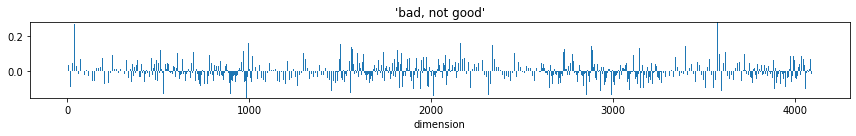



tensor([-0.0135, -0.1321,  0.0046,  ...,  0.0547,  0.0598,  0.0181])


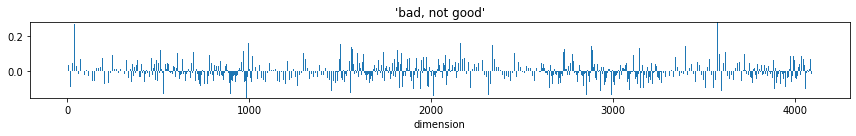



tensor([-0.0089, -0.0060, -0.0049,  ..., -0.0202,  0.0502, -0.0502])


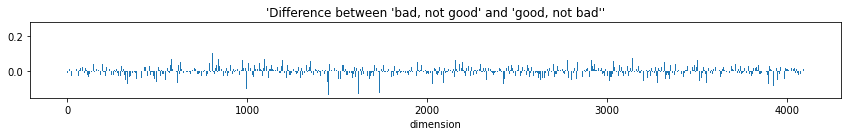

In [15]:
neg_sent = "bad, not good"
neg_emb = infsent_model.encoder.encode(neg_sent).squeeze()
visualize_embedding(neg_sent, neg_emb, [-0.15, 0.275])


pos_sent = "good, not bad"
pos_emb = infsent_model.encoder.encode(pos_sent).squeeze()
visualize_embedding(neg_sent, neg_emb, [-0.15, 0.275])

diff_emb = neg_emb - pos_emb
visualize_embedding(
    "Difference between 'bad, not good' and 'good, not bad'", diff_emb, [-0.15, 0.275]
)

While the difference is indeed non-zero, we do note that the embeddings are quite similar despite the sentences having opposite meanings. This can be interpreted as word order not fully being exploited. 

This may be a limit of the models employed, which at best visit sentences sequentially in both directions, but cannot examine the sentences as a graph to construct inner representations akin to a parse tree, where word order becomes increasingly useful. At the expense of triteness, it would be interesting to extend the InferSent architecture with a transformer, BERT-like encoder for the sentences, to examine whether self-attention could be leveraged for improved SentEval performance.